# TinyGPT

**Author: Abraham R.**

The following notebook is an example of a really tiny GPT based model called TinyGPT.
You'll review the GPT architecture (transformer decoder) and implement the following tasks:

## TinyGPT Architecture

Tailored for the [NLP-II course](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/CEIA-LLMIAG) as we deal with architectures and theory, this model consists of a **Mixture of Experts GPT**, equivalent to models like:
- DeepSeek
- Mistral

## Tasks

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)

## Architecture:
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

## What to expect?

- You'll manage to understand a depth implementation of a GPT model.
- Implement a MoE Layer to create a state-of-the art GPT model.
- Explore decoding algorithms for text generation.


### NOTE

Tokenization is out of scope, we'll use a simple yet ineffective character-based tokenizer.


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

import tiktoken

## Downloading Dataset

In [2]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Tonenizer de OpenAI

In [3]:
encoding = tiktoken.get_encoding("cl100k_base")  # GPT-4

def encode(text: str) -> List[int]:
    return encoding.encode(text)

def decode(ids: List[int]) -> str:
    return encoding.decode(ids)

vocab_size = encoding.n_vocab
print(f"Vocab size: {vocab_size}")

Vocab size: 100277


In [4]:
data = torch.tensor(encode(text), dtype=torch.long)

# Train/test split
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Dataloaders

In [5]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# GPT Configuration

In [6]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 100277, 'bias': True, 'ff_class': None, 'moe': None}


In [7]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8,
                        )

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [10]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## TinyGPT Architecture

In [11]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits


## Generation function (inference)

In [12]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Setup

In [13]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

In [14]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10

# Training

In [15]:
# Trainer instance
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/3087 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
W1119 03:23:57.594000 770 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_induct

Epoch 1 training loss: 4.3152


  0%|          | 0/339 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 6.93947: 100%|██████████| 339/339 [00:03<00:00, 92.15it/s] 


Epoch 1 validation loss: 5.5583


loss 4.00776: 100%|██████████| 3087/3087 [01:29<00:00, 34.40it/s]


Epoch 2 training loss: 4.1576


val_loss 6.98288: 100%|██████████| 339/339 [00:03<00:00, 85.98it/s] 


Epoch 2 validation loss: 5.5742


loss 4.08426: 100%|██████████| 3087/3087 [01:29<00:00, 34.31it/s]


Epoch 3 training loss: 4.1296


val_loss 6.98512: 100%|██████████| 339/339 [00:03<00:00, 97.11it/s] 


Epoch 3 validation loss: 5.5755


loss 4.12725: 100%|██████████| 3087/3087 [01:29<00:00, 34.32it/s]


Epoch 4 training loss: 4.1258


val_loss 6.98523: 100%|██████████| 339/339 [00:03<00:00, 97.12it/s] 


Epoch 4 validation loss: 5.5756


loss 4.14202: 100%|██████████| 3087/3087 [01:29<00:00, 34.32it/s]


Epoch 5 training loss: 4.1717


val_loss 6.98523: 100%|██████████| 339/339 [00:03<00:00, 85.92it/s] 


Epoch 5 validation loss: 5.5756


loss 4.19674: 100%|██████████| 3087/3087 [01:29<00:00, 34.35it/s]


Epoch 6 training loss: 4.0313


val_loss 6.98523: 100%|██████████| 339/339 [00:03<00:00, 96.62it/s] 


Epoch 6 validation loss: 5.5756


loss 4.15197: 100%|██████████| 3087/3087 [01:29<00:00, 34.30it/s]


Epoch 7 training loss: 4.2404


val_loss 6.98523: 100%|██████████| 339/339 [00:03<00:00, 94.70it/s] 


Epoch 7 validation loss: 5.5756


loss 4.06636: 100%|██████████| 3087/3087 [01:30<00:00, 34.15it/s]


Epoch 8 training loss: 4.2084


val_loss 6.98523: 100%|██████████| 339/339 [00:03<00:00, 86.58it/s] 


Epoch 8 validation loss: 5.5756


loss 4.02368: 100%|██████████| 3087/3087 [01:30<00:00, 34.23it/s]


Epoch 9 training loss: 4.1671


val_loss 6.98523: 100%|██████████| 339/339 [00:03<00:00, 92.37it/s]


Epoch 9 validation loss: 5.5756


loss 4.16696: 100%|██████████| 3087/3087 [01:30<00:00, 34.24it/s]


Epoch 10 training loss: 4.0746


val_loss 6.98523: 100%|██████████| 339/339 [00:03<00:00, 95.60it/s] 


Epoch 10 validation loss: 5.5756
Training complete.


### Quick test

In [16]:
generate("To be", max_new_tokens=100,use_cache=True)

"To be bru as he did:\nCome, awake\nFast,h hold the rock.\n\nCORIOLANUS:\nI use he presume, wherein myicut youoble so.\n\nFirst Citizen:\nHelp no word I did fashion,\nNotretch could be warm a wife!\n\nVOLUMNIA:\nI could super merit voices him'd\np thirst my power, sure that now, and friends for bear to bear.\n\nCORIOLANUS:\nWe will not it isg do\nHark;We.\nHow"

# Task I

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)



In [17]:
# TODO Implement Greedy decoding, Temperature and top_k/top_p
@torch.no_grad()
def generateV2(
    prompt: str,
    model: nn.Module,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: Optional[int] = None,  # None = no aplicar
    top_p: Optional[float] = None,  # None = no aplicar
) -> Optional[str]:

    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        # Determinar entrada condicional
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        # Forward del modelo
        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits, kv_cache = out, None

        logits = logits[:, -1, :]

        # --- Greedy decoding (temperatura = 0 o muy baja) ---
        if temperature < 1e-8:
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
        else:
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)

            # --- Top-k sampling ---
            if top_k is not None and top_k > 0:
                top_k_probs, top_k_indices = torch.topk(probs, min(top_k, probs.size(-1)))
                probs = torch.zeros_like(probs)
                probs.scatter_(1, top_k_indices, top_k_probs)
                probs = probs / probs.sum(dim=-1, keepdim=True)

            # --- Top-p sampling ---
            if top_p is not None and top_p < 1.0:
                sorted_probs, sorted_indices = torch.sort(probs, descending=True)
                cumsum_probs = torch.cumsum(sorted_probs, dim=-1)

                # Remover tokens donde la prob acumulada excede top_p
                sorted_indices_to_remove = cumsum_probs > top_p
                # Mantener al menos el primer token
                sorted_indices_to_remove[..., 0] = False

                # Crear máscara en el orden original
                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                probs[indices_to_remove] = 0.0
                probs = probs / probs.sum(dim=-1, keepdim=True)

            # Muestrear
            next_token = torch.multinomial(probs, num_samples=1)

        # concatenar al prompt
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

## Compare generate vs generateV2

Add your comments and findings

In [18]:
print(generate("To be", max_new_tokens=100,use_cache=True))

To be his lip or heart.

Second Citizen:
What over beg'd
A second he didp came would them.twas not lady.activitiesHay, but sheepIRGILIA:
Have's,
He fearsantage, but side my ingr for Rome she him;
And the common choice.

VOLUMNIA:
Let.

VIRGILIA:
That I speak you not thank say their violent not to them, sir,
Though heard you voice your smiles will not to the people.

COMINIUS


In [19]:
print("=== GREEDY ===")
print(generateV2("To be", model, max_new_tokens=100, use_cache=True, temperature=0))

=== GREEDY ===
To be
To the people, and
To the people, and
To the people.

CORIOLANUS:
I'll make the people, I'll be
To the people, and
To the people, and
To the people, and
To the people, and
To the people, and
To the people, and
To the people, and
To the people, and
To the people, and
To the people, and
To the people, and
To


In [20]:
print("=== TEMP 0.7 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=0.7))

=== TEMP 0.7 ===
To be you
In block, and shall be still him; the embracements him, they
Thou with such pleased.

First Senator:
I'll since, my nature; so than a veryus were,
That you
We'll be fright I'll be bold ashall,
Andbench we have been enough their
A place, sir, if the moon you Aufidius, let
Against his gracious'Tis; bas spo rabis no.

MENIUS:
You have been us.




In [21]:
print("=== TOP-K=10 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=1.0, top_k=10))

=== TOP-K=10 ===
To be
That, and hear the city as you
The common
To be consul's the gods
The gods. For with me, that will, and
Than he was wont; for the other.

MARCIUS:
He's one you are you may be
Than, sir: and have you to make the state; and
In honour, sir of a
In our own the gods, and
As and my love, I am my good
And that he wore, and



In [22]:
print("=== TOP-K=40 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=1.0, top_k=40))

=== TOP-K=40 ===
To be content.

SICINIUS:
Come, I'll leave no further
Worthy that the people,
The people, being'erwhel see your husband you in the cityus Marcius?

T thoughtENIUS:
F way to this was
Of the commonon.

MENENIUS:
Ay, I know, he would hear me, sir, if the matter,
and the people,
Which he will be angry, so
Than in me. Come my love.

MEN


In [23]:
print("=== TOP-P=0.9 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=1.0, top_p=0.9))

=== TOP-P=0.9 ===
To be once you so,
Before that's p noble voice a done's
The people,
T life upon to the leg are what my way?

SICINIUS:
Come, calling, val old for
From I am by you to you have noteech, we that
Upon for them, not that atiles, though, if the letter!' youied.

BRUTUS:
O, you shall blood.

SICINIUS:
Why, when at noble old
not!

BRUT


In [24]:
print("=== TEMP 0.7 + TOP-P 0.9 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=0.7, top_p=0.9))

=== TEMP 0.7 + TOP-P 0.9 ===
To be consul.

VOLUMNIA:
I shall had rather, and and know you.

COMINIUS:
He's in my lord.

BRUTUS:
I have been, as you, you have your dis bear.

First Citizen:
You have been's I do not upon the people, sir, sir.

MENENIUS:
You have heard I amtis, what, I think
Where, and the Capitol; for a
That's news.

First Senator:
We, I am


In [25]:
print("=== TEMP 1.5 + TOP-K=50 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=1.5, top_k=50))

=== TEMP 1.5 + TOP-K=50 ===
To be that he, and fight
They'll their prov desire all
My services.

Fourth upon that was the market-place you, which'd
Of not be: where,
How so humbleee'd that ever his good what they cannot
Against the frown with be to make what Cor eldersus!
O? us.

L, sir:
Let and that's my lord: therefore
I will make them, and in time; for your bis. By the matter: and not all my lord a


In [26]:
print("=== TEMP 0.5 + TOP-P 0.8 ===")
print(generateV2("To be", model, max_new_tokens=50, temperature=0.5, top_p=0.8))

=== TEMP 0.5 + TOP-P 0.8 ===
To be content
Than with the people, and
That the city, and in the matter.

MENENIUS:
I have been, no more of the people, and
To the gods.

CORIOLANUS:
No, and



## Task II
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

In [27]:
class Expert(nn.Module):
    """Expert con arquitectura SwiGLU (state-of-the-art)"""
    def __init__(self, config: GPTConfig) -> None:
        super().__init__()
        hidden_dim = 4 * config.n_embd

        self.w1 = nn.Linear(config.n_embd, hidden_dim, bias=False)  # gate
        self.w2 = nn.Linear(config.n_embd, hidden_dim, bias=False)  # up
        self.w3 = nn.Linear(hidden_dim, config.n_embd, bias=False)  # down
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x) -> torch.Tensor:
        # SwiGLU: silu(w1(x)) ⊙ w2(x)
        return self.dropout(self.w3(F.silu(self.w1(x)) * self.w2(x)))


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [28]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, C)
        """
        B, T, C = x.size()
        num_experts = len(self.experts)
        k = self.args.num_experts_per_token

        # ---- 1. Compute gating logits and probabilities ----
        gate_logits = self.gate(x)                      # (B, T, E)
        gate_probs = F.softmax(gate_logits, dim=-1)     # (B, T, E)

        # ---- 2. Select top-k experts per token ----
        topk_weights, topk_idx = torch.topk(gate_probs, k, dim=-1)   # (B, T, k)

        # Normalizar los pesos top-k para que sumen 1
        topk_weights = topk_weights / topk_weights.sum(dim=-1, keepdim=True)  # (B, T, k)

        # ---- 3. Flatten para procesamiento por lotes ----
        x_flat = x.view(-1, C)  # (B*T, C)

        # Preparar salida
        output = torch.zeros_like(x_flat)  # (B*T, C)

        # ---- 4. Procesar cada expert ----
        for i in range(num_experts):
            # Encontrar qué tokens van al expert i
            # topk_idx: (B, T, k) -> queremos saber si i está en alguno de los k
            expert_mask = (topk_idx == i).any(dim=-1)  # (B, T)
            expert_mask_flat = expert_mask.view(-1)    # (B*T,)

            if expert_mask_flat.sum() == 0:
                continue  # No hay tokens para este expert

            # Obtener tokens que van al expert i
            expert_input = x_flat[expert_mask_flat]  # (N, C) donde N = num tokens
            expert_output = self.experts[i](expert_input)  # (N, C)

            # Obtener los pesos correspondientes
            # Para cada token en expert_input, necesitamos su peso
            # topk_idx (B, T, k) -> ver en qué posición de k está el expert i
            flat_topk_idx = topk_idx.view(B*T, k)  # (B*T, k)
            flat_topk_weights = topk_weights.view(B*T, k)  # (B*T, k)

            # Para los tokens seleccionados, obtener sus pesos
            selected_topk_idx = flat_topk_idx[expert_mask_flat]  # (N, k)
            selected_topk_weights = flat_topk_weights[expert_mask_flat]  # (N, k)

            # Encontrar en qué posición está el expert i para cada token
            expert_weights = torch.zeros(selected_topk_idx.size(0), device=x.device)
            for j in range(k):
                mask_j = (selected_topk_idx[:, j] == i)
                expert_weights[mask_j] = selected_topk_weights[mask_j, j]

            # Aplicar pesos y acumular
            weighted_output = expert_output * expert_weights.unsqueeze(-1)
            output[expert_mask_flat] += weighted_output

        # ---- 5. Reshape de vuelta ----
        output = output.view(B, T, C)
        return output

In [29]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(
            experts=[Expert(config) for _ in range(config.moe.num_experts)],
            gate=Gate(config),
            moe_args=config.moe
        )

    def forward(self, x):
        return self.moe(x)

## Adding MoE to Config

In [30]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=2)

# Training TinyGPT-MoE


In [31]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m_moe)

In [32]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10

In [33]:
# Trainer instance
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/3087 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
loss 3.91517: 100%|██████████| 3087/3087 [03:14<00:00, 15.85it/s]


Epoch 1 training loss: 4.0022


  0%|          | 0/339 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 6.88072: 100%|██████████| 339/339 [00:07<00:00, 47.07it/s]


Epoch 1 validation loss: 5.5149


  0%|          | 0/3087 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
loss 3.80381: 100%|██████████| 3087/3087 [03:12<00:00, 16.02it/s]


Epoch 2 training loss: 3.7332


val_loss 6.93320: 100%|██████████| 339/339 [00:06<00:00, 50.64it/s]


Epoch 2 validation loss: 5.5367


loss 3.82717: 100%|██████████| 3087/3087 [03:11<00:00, 16.08it/s]


Epoch 3 training loss: 3.8386


val_loss 6.93693: 100%|██████████| 339/339 [00:06<00:00, 48.87it/s]


Epoch 3 validation loss: 5.5380


loss 3.82419: 100%|██████████| 3087/3087 [03:08<00:00, 16.34it/s]


Epoch 4 training loss: 3.7723


val_loss 6.93700: 100%|██████████| 339/339 [00:07<00:00, 47.62it/s]


Epoch 4 validation loss: 5.5381


loss 3.73884: 100%|██████████| 3087/3087 [03:10<00:00, 16.20it/s]


Epoch 5 training loss: 3.7532


val_loss 6.93700: 100%|██████████| 339/339 [00:06<00:00, 48.83it/s]


Epoch 5 validation loss: 5.5381


loss 3.75865: 100%|██████████| 3087/3087 [03:11<00:00, 16.14it/s]


Epoch 6 training loss: 3.8584


val_loss 6.93700: 100%|██████████| 339/339 [00:06<00:00, 51.50it/s]


Epoch 6 validation loss: 5.5381


loss 3.72360: 100%|██████████| 3087/3087 [03:10<00:00, 16.25it/s]


Epoch 7 training loss: 3.9010


val_loss 6.93700: 100%|██████████| 339/339 [00:06<00:00, 50.31it/s]


Epoch 7 validation loss: 5.5381


loss 3.82712: 100%|██████████| 3087/3087 [03:11<00:00, 16.16it/s]


Epoch 8 training loss: 3.9016


val_loss 6.93700: 100%|██████████| 339/339 [00:07<00:00, 47.77it/s]


Epoch 8 validation loss: 5.5381


loss 3.71978: 100%|██████████| 3087/3087 [03:09<00:00, 16.26it/s]


Epoch 9 training loss: 3.7145


val_loss 6.93700: 100%|██████████| 339/339 [00:07<00:00, 47.92it/s]


Epoch 9 validation loss: 5.5381


loss 3.83084: 100%|██████████| 3087/3087 [03:08<00:00, 16.35it/s]


Epoch 10 training loss: 3.7568


val_loss 6.93700: 100%|██████████| 339/339 [00:07<00:00, 46.92it/s]

Epoch 10 validation loss: 5.5381
Training complete.


In [34]:
print("=== GREEDY ===")
print(generateV2("To be", model_moe, max_new_tokens=100, use_cache=True, temperature=0))

=== GREEDY ===
To be consul.

MENENIUS:
IUS:
I'll hear me, and to the people, and
To the people, and the people,
And that you, and
To the people,
And that you to the people,
And that you to the people,
And that you to the people,
And that you to the people,
And that you to the people,
And that you to the people,
And that you to the people,
And that you to the people,
And that you


In [35]:
print("=== TEMP 0.7 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=0.7))

=== TEMP 0.7 ===
To be consul: the store
cause: and I am fear
dis power to me.

MENENIUS:
He he did before him.

BRUTUS:
Indeed, they did, if you.
O, and their report;
Em:
Well, sir; to doth, my lord.

VIRGILIA:
What is that they have been their scar a sword, and to what he is than!

LARTIUS:
What do with him.

MENIUS:
Well


In [36]:
print("=== TOP-K=10 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=1.0, top_k=10))

=== TOP-K=10 ===
To be
In their caps
With his country: if you, but he
The common way to Rome of the people
Than my nature,
You shall answer to you have done.

CORI have fought together, and to be consul, and the nobly?

BRUTUS:
He had you.

MARCIUS:
He'stis true.

CORI'll beatst a man.

BRUTUS:
We have
AEdile:
IOLANUS:
IOLANUS:
You


In [37]:
print("=== TOP-K=40 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=1.0, top_k=40))

=== TOP-K=40 ===
To be he
Than not a man: but, by thither
The man, my mother well in my lord.
With the city. Goded of me m milder,
If he wore you, sir, and charge
Than was the wars
And you shall be. You have been
The people.

MENIUS:
This is, you, they would be the market-place!

CORIUS:
The prayers of your loves,
Thou him, but is the people,
Which we


In [38]:
print("=== TOP-P=0.9 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=1.0, top_p=0.9))

=== TOP-P=0.9 ===
To be consul.

First Citizen:
I'll but a lamb of doors that has madeARTI would
any of pretty was a strongest do you think to the people home
Thy mag their facesuc owns every name,
That that will, my audit,
Ere of the Capitol'd in if
once of they set the gates home of the increase
By we'll induced end'd to gentry to do back 'twas he
two'd cry
Coriolanus, took: 'Citizens


In [39]:
print("=== TEMP 0.7 + TOP-P 0.9 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=0.7, top_p=0.9))

=== TEMP 0.7 + TOP-P 0.9 ===
To be gone
Worthy me with what I will I may be from you have my lord.

COMINIUS:
The sweet
Shall bear the richst rather you to have
From him.

CORIOLANUS:
Hear me: 'tis a mile, he did, Marcius Lartius,
And of your voices,
Which we were now, which
Be-m ins't:
We have me, and good madam.

COMINIUS:
O, no more.




In [40]:
print("=== TEMP 1.5 + TOP-K=50 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=1.5, top_k=50))

=== TEMP 1.5 + TOP-K=50 ===
To be proud.

VALERIA COR, or if you give you are like these too late I would relieve me it from him.

SICINIUS:
The blood you, you give.

MAR at
My gracious speak with rushes.

MARCIUS:
How now, not show true: you have found a person with my lord than you not done with him,--is well; that have found be put the nobles the world!

Lest you to hear your hate.

COMINIUS:
Why


In [41]:
print("=== TEMP 0.5 + TOP-P 0.8 ===")
print(generateV2("To be", model_moe, max_new_tokens=50, temperature=0.5, top_p=0.8))

=== TEMP 0.5 + TOP-P 0.8 ===
To be gone, that
The gods give you have been sup not
The people, sir, you, I will not be consul.

BRUTUS:
What is the people, and to be, and go.

CORIOLANUS:
IOL


## Visualizing Attention

As we know, a GPT has the task to complete text, let's see the attention maps generated by a pretrained model

In [42]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()


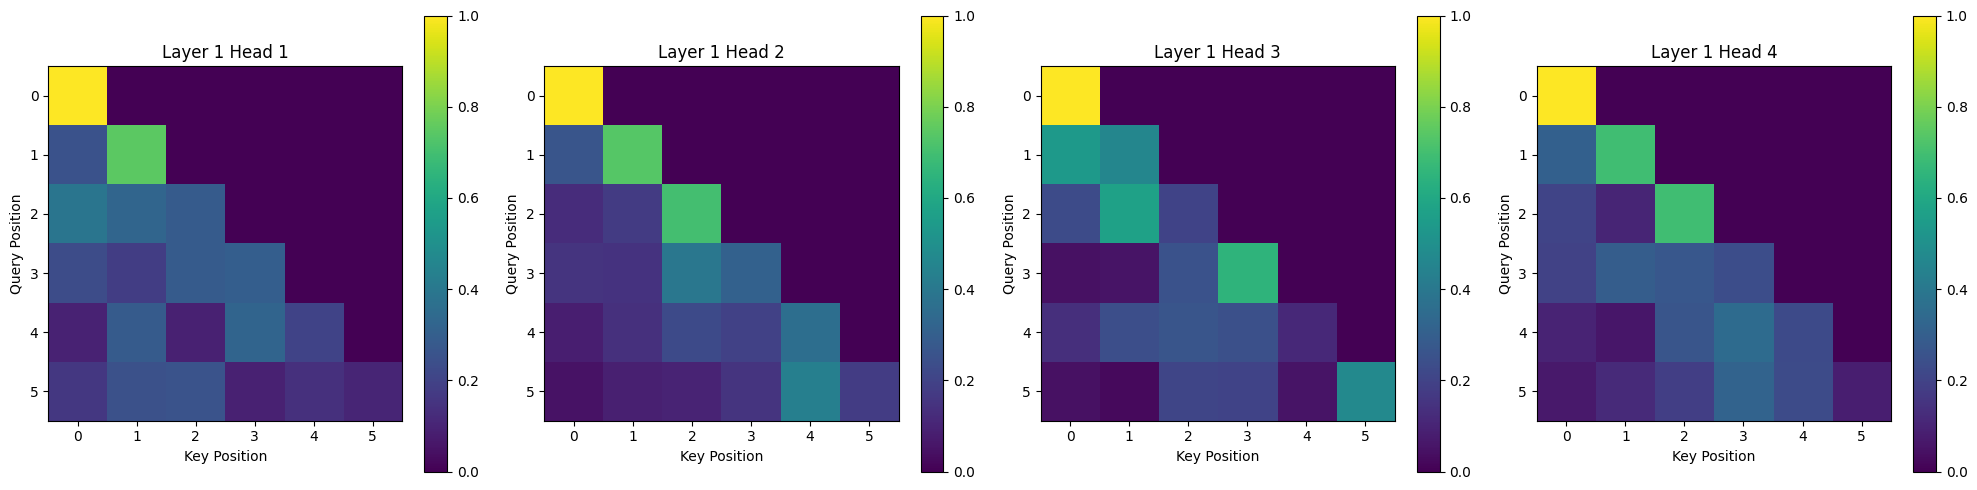

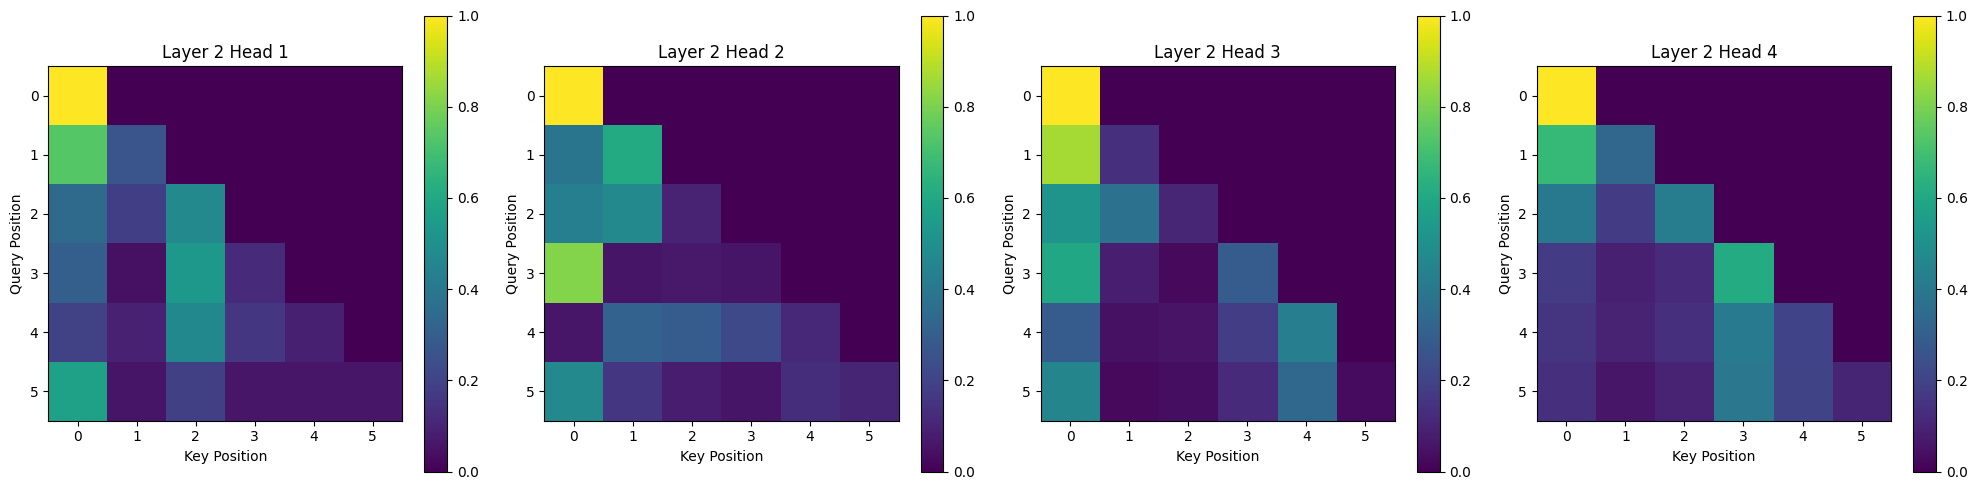

In [43]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

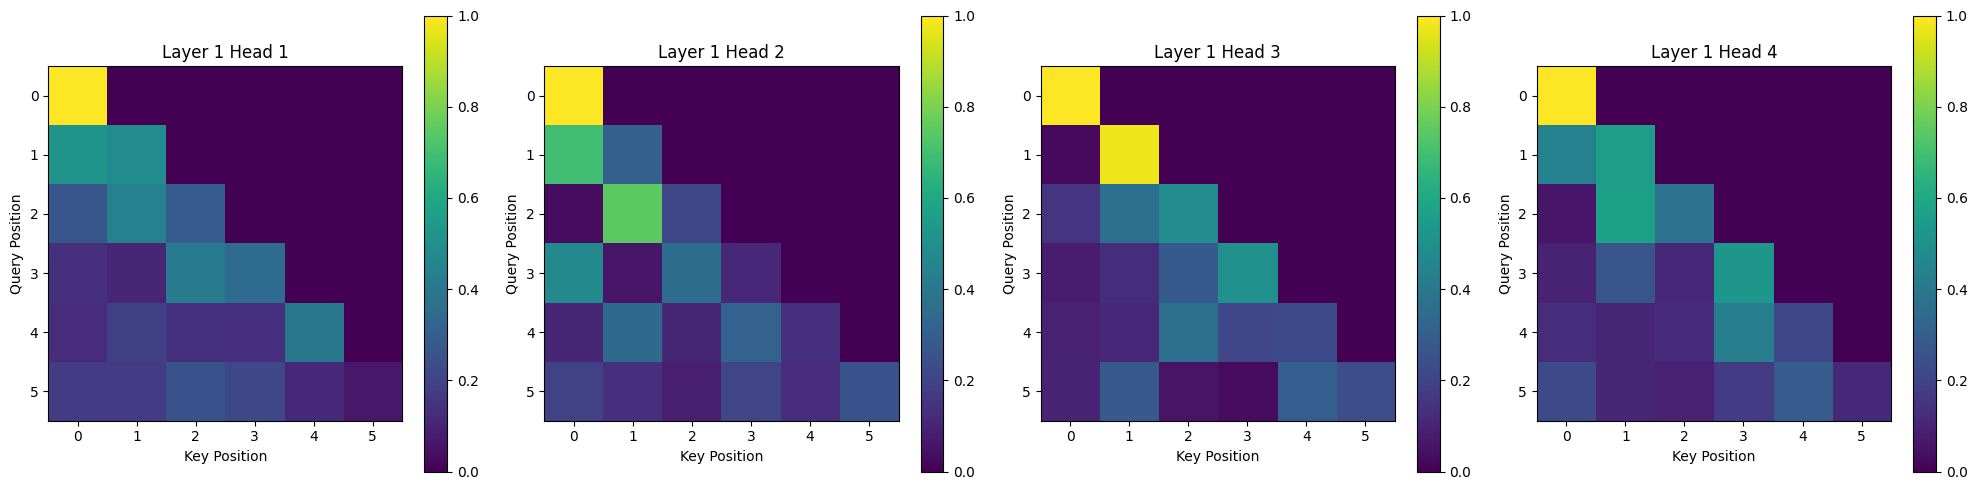

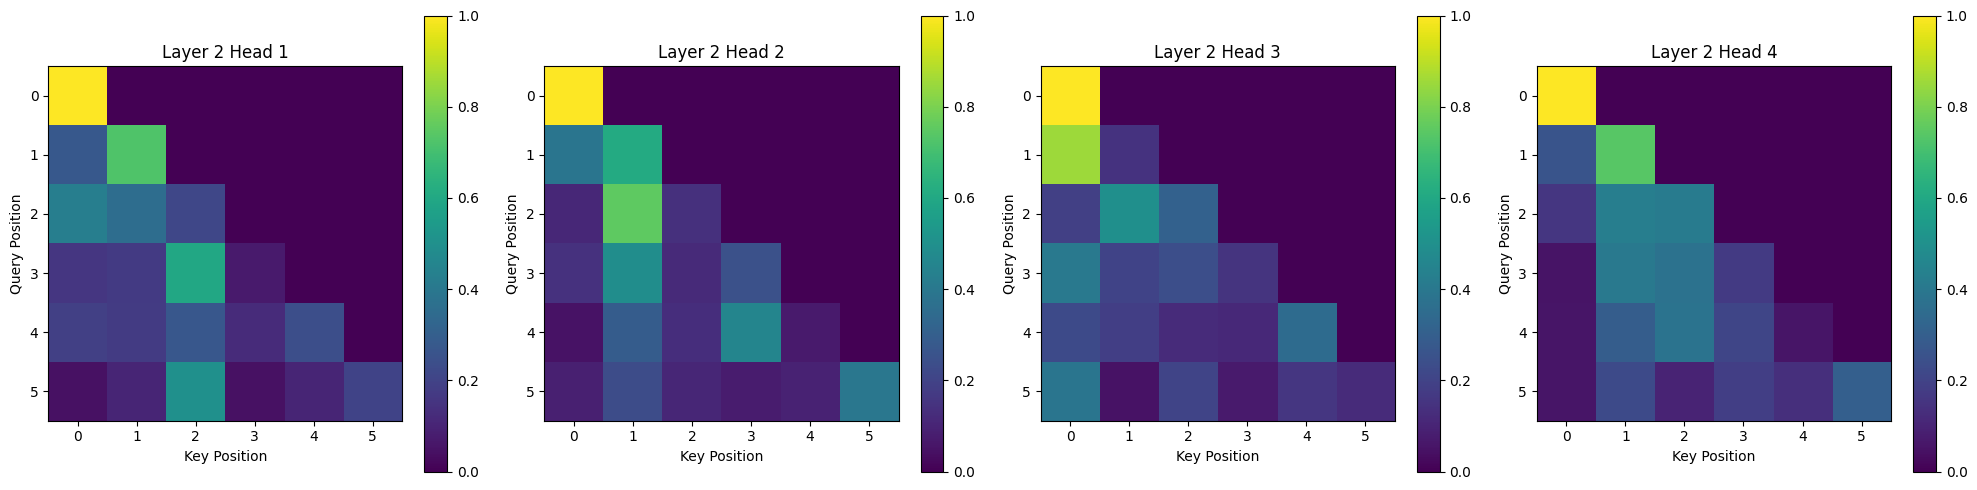

In [44]:
visualize_attention(model_moe, prompt)

# Conclusions

- Los nuevos mapas de atención muestran patrones mucho más nítidos debido a que, con tiktoken, las secuencias pasaron a ser más cortas, reduciendo el tamaño de las matrices y haciendo más visible la estructura autoregresiva.

- La menor cantidad de tokens permitió observar de manera más clara la función de cada cabeza, destacando las diagonales y los picos de atención sin el ruido visual que aparecía en secuencias largas.

- Los cambios en la tokenización modificaron la distribución de los tokens, lo que a su vez produjo variaciones en cómo el modelo reparte la atención entre posiciones, aun sin alterar la arquitectura del transformer.

- Las cabezas muestran roles diferenciados de forma más evidente gracias a la escala reducida: algunas se concentran en dependencias locales, mientras que otras capturan relaciones más amplias.

- Las generaciones resultantes mantienen coherencia, pero reflejan las diferencias en los tokens de entrada: secuencias más cortas y limpias producen salidas más directas y menos redundantes.

- El comportamiento general del modelo se mantiene, pero los gráficos de esta versión permiten interpretarlo con mayor claridad gracias a la combinación de una tokenización distinta y un contexto de evaluación más reducido.

- En conjunto, esta versión mejora la interpretabilidad del modelo sin modificar su arquitectura, evidenciando cómo el preprocesamiento y la longitud del input influyen directamente en la apariencia de los mapas de atención y en la dinámica de generación.

# Congratulations! 🎉

After completing the tasks you've successfully pretrained for first GPT, remember to add your conclusions and findings! And you can now brag to your friend on how LLMs and GPTs work!

